In [68]:
import cv2
import numpy as np

In [69]:
import cv2
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
from transformers.utils import logging
logging.set_verbosity_info()


In [70]:
# Load model & processor
#use base instead of small if bad accuracy irl
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')


loading configuration file preprocessor_config.json from cache at C:\Users\mahmoud\.cache\huggingface\hub\models--microsoft--trocr-small-handwritten\snapshots\b4648cfa171985a6745f37ddd637e98c0da958ac\preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 384. Converted to {'height': 384, 'width': 384}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image

In [131]:

class BubbleSheetProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.nc = None
        self.image = None
        self.gray = None
        self.warped = None
        self.cropped = None
        self.thresh = None
        self.bubble_contours = None
        self.answer_matrix = None
        self.student_id=None
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h=None,None,None,None
        self.marker_area=None

    def load_image(self):
        self.image = cv2.imread(self.image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def get_id_corner_map(self):
        aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)
        parameters = cv2.aruco.DetectorParameters()
        detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

        corners, ids, _ = detector.detectMarkers(self.gray)
        if ids is None or len(ids) < 4:
            raise ValueError("Not all 4 ArUco markers were detected.")

        id_corner_map = {id[0]: corner for id, corner in zip(ids, corners)}

        if 48 in id_corner_map:
            self.nc = 5
        elif 49 in id_corner_map:
            self.nc = 4
        else:
            raise ValueError("Required ArUco marker not found.")
        #give the area of a circle with diameter equals to the edge of a marker
        marker_arr=id_corner_map[30]
        self.marker_area=np.pi*(int(abs(marker_arr[0][1][0]-marker_arr[0][0][0]))/2)**2
        return id_corner_map

    def get_center(self, corner):
        return corner[0].mean(axis=0)

    def get_centroid(self, array):
        return np.array(array).mean(axis=0)

    def get_roi(self, id_corner_map):
        if 48 in id_corner_map:
            ordered_ids = [30, 10, 48, 34]  # TL, TR, BR, BL
        else:  # 49 is guaranteed if 48 isn't
            ordered_ids = [30, 10, 49, 34]

        ordered_pts = [self.get_center(id_corner_map[id]) for id in ordered_ids]
        return np.array(ordered_pts, dtype='float32')

    def get_warped_image(self, src_pts):
        width, height = int(self.image.shape[0] * 0.764), self.image.shape[0]
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype='float32')

        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        return cv2.warpPerspective(self.image, M, (width, height))

    def get_largest_contour(self, image, drawContour=False):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(
            gray, 255, 
            cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY_INV, 
            25, 4
        )
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        largest_contour = max(contours, key=cv2.contourArea)

        if drawContour:
            cv2.drawContours(image, largest_contour, -1, (0, 255, 0), 3)
            cv2.imshow('largest contour', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        return largest_contour
    
    def warp_paper(self):
        id_corner_map = self.get_id_corner_map()
        roi = self.get_roi(id_corner_map)
        self.warped = self.get_warped_image(roi)

    def preprocess_cropped(self):
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h = cv2.boundingRect(self.get_largest_contour(self.warped))
        self.cropped = self.warped[self.bubbles_area_y+10:self.bubbles_area_y+self.bubbles_area_h-10, 
                                    self.bubbles_area_x+10:self.bubbles_area_x+self.bubbles_area_w-10]
        
        cropped_gray = cv2.cvtColor(self.cropped, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(cropped_gray, (3, 3), 0)

        self.thresh = cv2.adaptiveThreshold(
            blurred, 255, 
            cv2.ADAPTIVE_THRESH_MEAN_C, 
            cv2.THRESH_BINARY_INV, 
            25, 4
        )

    def extract_bubble_contours(self, drawContours=False):
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        bubble_contours = []

        for c in contours:
            area = cv2.contourArea(c)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)

            if area > self.marker_area and 0.9 < aspect_ratio < 1.1:
                bubble_contours.append(c)

        bubble_contours.sort(key=lambda b: self.get_centroid(b)[0][1])

        for i in range(10):  # 10 rows expected
            start = i * self.nc * 3
            end = (i + 1) * self.nc * 3
            bubble_contours[start:end] = sorted(
                bubble_contours[start:end],
                key=lambda b: self.get_centroid(b)[0][0]
            )

        if drawContours:
            output = self.cropped.copy()
            cv2.drawContours(output, bubble_contours, -1, (0, 255, 0), 2)
            output_resized = cv2.resize(output, (800, int(output.shape[0] * 800 / output.shape[1])))
            cv2.imshow('Detected Bubbles', output_resized)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        self.bubble_contours = bubble_contours

    def get_filled_bubbles_matrix(self):
        extracted = []

        for c in self.bubble_contours:
            mask = np.zeros(self.thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            masked = cv2.bitwise_and(self.thresh, self.thresh, mask=mask)

            total = cv2.countNonZero(mask)
            filled = cv2.countNonZero(masked)
            ratio = filled / total

            extracted.append(1 if ratio > 0.5 else 0)

        self.answer_matrix = np.array(extracted).reshape(-1, self.nc)
    def detect_student_id(self,drawContours=False):
        id_area=self.warped[0:self.bubbles_area_y, int(self.warped.shape[1]*.75):]
        x, y, w, h = cv2.boundingRect(self.get_largest_contour(id_area))
        
        student_id_img=id_area[y+5:y+h-5, x+5:x+w-5]
        
        pixel_values = processor(images=student_id_img, return_tensors="pt").pixel_values
        # Run inference
        generated_ids = model.generate(pixel_values,max_length=14,min_length=4,num_beams =2,early_stopping =True,repetition_penalty=.8)
        self.student_id = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        if drawContours:
            output = id_area.copy()
            cv2.drawContours(output, self.get_largest_contour(id_area), -1, (0, 255, 0), 2)
            output_resized = cv2.resize(output, (800, int(output.shape[0] * 800 / output.shape[1])))
            cv2.imshow('Detected Bubbles', output_resized)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        
    
    def run_pipeline(self):
        self.load_image()
        self.warp_paper()
        self.preprocess_cropped()
        self.extract_bubble_contours()
        self.get_filled_bubbles_matrix()
        self.detect_student_id()
        return self.student_id, self.answer_matrix


In [137]:
import time
s=time.time()
sheet_processor=BubbleSheetProcessor('Downloads/s1.jpg')
print(sheet_processor.run_pipeline())
print(time.time()-s)

('01098255', array([[1, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]]))
0.9106853008270264


In [260]:
def get_results(model_answer_image, *students_answers_images):
    processor=BubbleSheetProcessor(model_answer_image)
    _,mam=processor.run_pipeline()
    
    for student_answer in students_answers_images:
        processor=BubbleSheetProcessor(student_answer)
        student_id,sam=processor.run_pipeline()
        sam==mam
        print(student_id,np.all(sam==mam,axis=1).sum())
        
    

In [261]:
get_results('Downloads/m.jpg','Downloads/s1.jpg')

AttributeError: 'numpy.ndarray' object has no attribute 'generate'

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import pandas as pd

num_students = 57
num_questions = 60
num_cheaters = 3
num_choices=4

# Create model answer (the "correct" one)
model = np.zeros((num_questions, num_choices), dtype=int)
for i in range(num_questions):
    model[i, i % num_choices] = 1

# Helper function to generate a believable answer
def generate_student_answer(model, accuracy=0.6):
    answer = np.zeros_like(model)
    for i in range(model.shape[0]):
        if np.random.rand() < accuracy:
            correct_choice = np.argmax(model[i])
        else:
            # Wrong answer, choose randomly excluding the correct one
            choices = list(set(range(num_choices)) - {np.argmax(model[i])})
            correct_choice = np.random.choice(choices)
        answer[i, correct_choice] = 1
    return answer


# Generate student accuracies using normal distribution with appropriate parameters
student_accuracies = np.clip(np.random.normal(0.6, 0.1, size=num_students), 0.3, 0.9)

# Generate regular student answers
students = [generate_student_answer(model, accuracy=acc) for acc in student_accuracies]

# Create cheater base with a higher mean accuracy
cheater_accuracy = np.clip(np.random.normal(0.75, 0.05), 0.65, 0.85)
cheater_base = generate_student_answer(model, accuracy=cheater_accuracy)

# Create 3 cheaters from the base with slight variations
cheaters = []
for i in range(num_cheaters):
    cheater = cheater_base.copy()
    # Introduce a small chance of changing a few answers for realism
    for j in range(num_questions):
        if np.random.rand() < 0.1:  # 10% chance to change
            cheater[j] = np.zeros(num_choices)
            cheater[j, np.random.randint(0, num_choices)] = 1
    cheaters.append(cheater)


# Combine all students and cheaters
students.extend(cheaters)


scores = np.array([np.sum(np.all(student == model, axis=1)) for student in students])




In [211]:
from sklearn.cluster import DBSCAN
X = np.array([student.flatten() for student in students])
clustering = DBSCAN(eps=.1, min_samples=2,metric='hamming').fit(X)

labels = clustering.labels_


In [212]:
colors=[]
for L in labels:
    if L==0:
        colors.append('red')
    elif L==1:
        colors.append('blue')
    else:
        colors.append('gray')
    

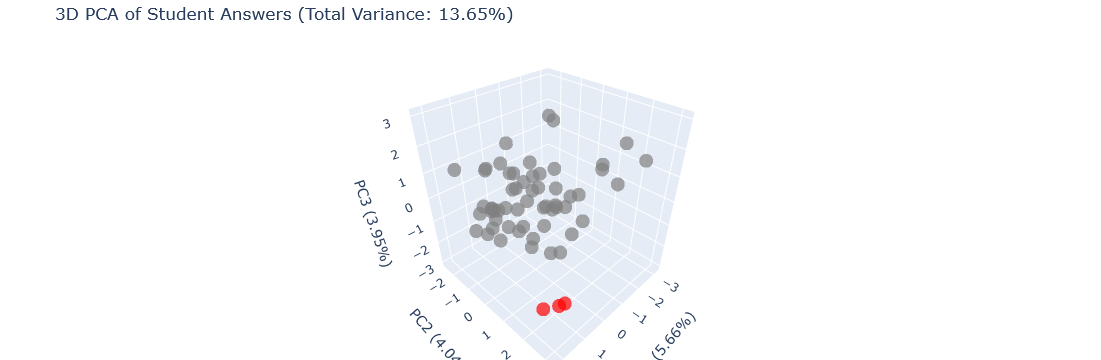

Variance explained by each principal component:
PC1: 5.66%
PC2: 4.04%
PC3: 3.95%
Total variance explained by first 3 PCs: 13.65%


In [213]:
# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_
total_variance = sum(explained_variance)

student_ids = [f"Student {i+1}" for i in range(num_students + num_cheaters)]


# Convert to DataFrame for plotly
df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Student_ID': student_ids,
    'Score': scores,
    'Color': colors
})

# Create interactive 3D plot with Plotly
fig = go.Figure()

# Add all students as scatter points
fig.add_trace(go.Scatter3d(
    x=df['PC1'],
    y=df['PC2'],
    z=df['PC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=df['Color'],
        opacity=0.7
    ),
    text=df['Student_ID'],
    hovertemplate=
    '<b>%{text}</b><br>' +
    'Score: %{customdata[0]}<br>' +
    'PC1: %{x:.2f}<br>' +
    'PC2: %{y:.2f}<br>' +
    'PC3: %{z:.2f}',
    customdata=np.stack((df['Score'],), axis=-1)
))

# Update the layout
fig.update_layout(
    title=f'3D PCA of Student Answers (Total Variance: {total_variance:.2%})',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]:.2%})',
        yaxis_title=f'PC2 ({explained_variance[1]:.2%})',
        zaxis_title=f'PC3 ({explained_variance[2]:.2%})',
    ),
    font=dict(size=12),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False
)

# Show the figure
fig.show()

# Print variance explained
print("Variance explained by each principal component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.2%}")
print(f"Total variance explained by first 3 PCs: {total_variance:.2%}")

# For environments that can't display interactive plotly plots,
# save as HTML file that can be opened in any browser
#fig.write_html("pca_visualization_3d.html")


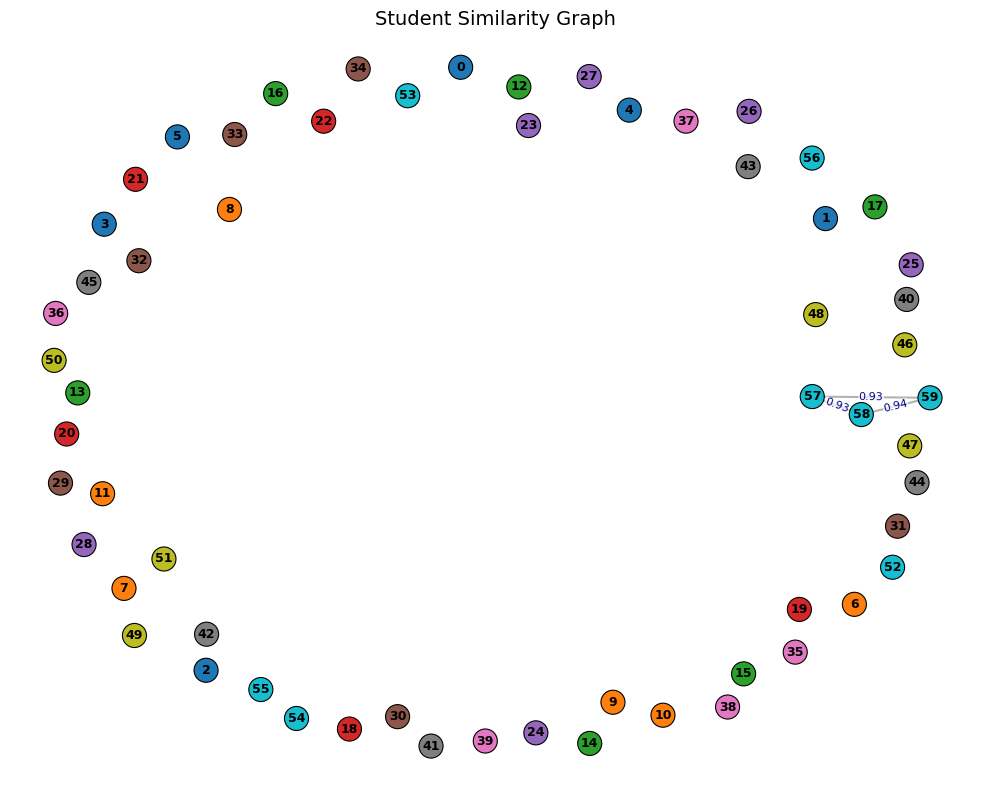

In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import community as community_louvain

# Step 1: Flatten student answers
X = np.array([student.flatten() for student in students])

# Step 2: Compute pairwise Hamming similarity
D = pairwise_distances(X, metric='hamming')
S = 1 - D

# Step 3: Create the graph with a threshold
threshold = 0.9
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i)
    for j in range(i + 1, len(X)):
        if S[i, j] > threshold:
            G.add_edge(i, j, weight=S[i, j])

# Step 4: Louvain community detection
partition = community_louvain.best_partition(G)

# Step 5: Simple, clean visualization with edge labels
plt.figure(figsize=(10, 8), facecolor='white')

# Use a simpler layout
pos = nx.spring_layout(G, k=0.4, seed=42)

# Draw edges - simple gray
nx.draw_networkx_edges(G, pos, 
                      width=1.5,
                      alpha=0.6,
                      edge_color='gray')

# Draw nodes - simple coloring by community
colors = [partition.get(node) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, 
                      node_color=colors, 
                      cmap=plt.cm.tab10,
                      node_size=300, 
                      edgecolors='black',
                      linewidths=0.8)

# Add node labels
nx.draw_networkx_labels(G, pos, 
                       font_size=9, 
                       font_color='black',
                       font_weight='bold')

# Add edge labels showing the similarity values (rounded to 2 decimal places)
edge_labels = {(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, 
                            edge_labels=edge_labels,
                            font_size=8,
                            font_color='darkblue',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.3))

plt.title("Student Similarity Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()
fig.update_layout(dragmode='pan')  # Default mode, but users can switch to 'select' or 'lasso'
fig.write_html("interactive_student_network.html", full_html=True)

In [20]:
import numpy as np
import networkx as nx
import json
from sklearn.metrics import pairwise_distances
import community as community_louvain

# Assuming 'students' is defined somewhere in your code
# Step 1: Flatten student answers
X = np.array([student.flatten() for student in students])

# Step 2: Compute pairwise Hamming similarity
D = pairwise_distances(X, metric='hamming')
S = 1 - D

# Step 3: Create the graph with a threshold
threshold = 0.9
G = nx.Graph()
for i in range(len(X)):
    G.add_node(i)
    for j in range(i + 1, len(X)):
        if S[i, j] > threshold:
            G.add_edge(i, j, weight=S[i, j])

# Step 4: Louvain community detection
partition = community_louvain.best_partition(
    G,
    weight='weight',
    resolution=1.0,
    randomize=False,
    random_state=42
)
# Prepare data for vis.js
network_data = {
    "nodes": [],
    "edges": []
}

# Add nodes with community information
for node in G.nodes():
    network_data["nodes"].append({
        "id": node,
        "label": str(node),
        "group": partition[node],
        "title": f"Student {node} (Community {partition[node]})"
    })

# Add edges with weights
for edge in G.edges():
    network_data["edges"].append({
        "from": edge[0],
        "to": edge[1],
        "value": G[edge[0]][edge[1]]["weight"],
        "title": f"Similarity: {G[edge[0]][edge[1]]['weight']:.2f}"
    })

# Save to JSON file
with open('student_network.json', 'w') as f:
    json.dump(network_data, f, indent=2)

print("Network data saved to student_network.json")

Network data saved to student_network.json
